In [1]:
import os
import json
import tqdm
import torch
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from torchvision.models import convnext_tiny
from torchvision.models.convnext import ConvNeXt_Tiny_Weights

### Data

In [14]:
# 訓練集資料夾路徑
train_folder = "./img/train"
# test 資料夾路徑
test_folder = "./img/test"

In [3]:
# 定義圖像轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 將圖像調整為模型輸入的大小
    transforms.ToTensor(),           # 將圖像轉換為 PyTorch 張量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 圖像歸一化
])

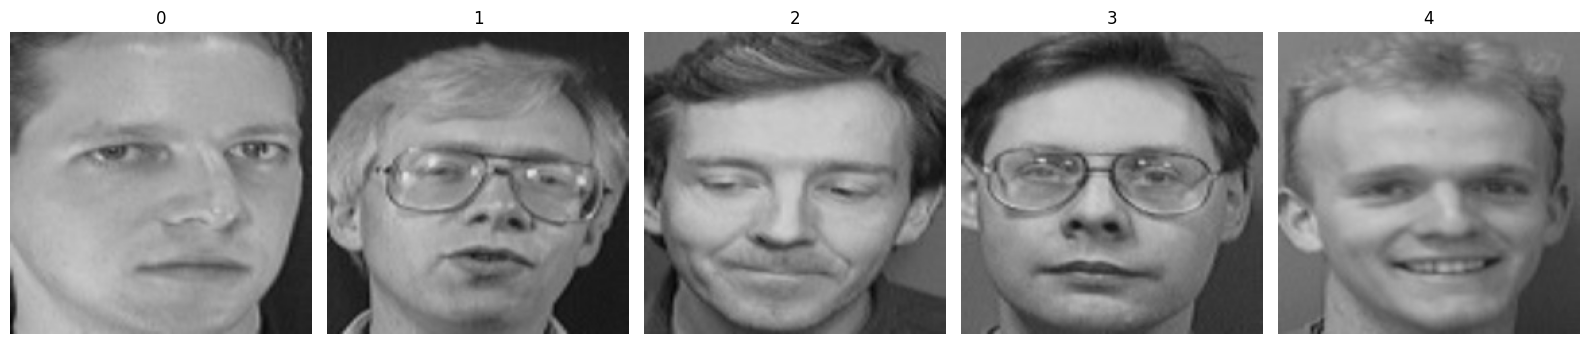

In [4]:
# 訓練集資料夾路徑
train_folder = "./img/train"

# 訓練集各個類別的資料夾列表
class_folders = [os.path.join(train_folder, class_folder) for class_folder in os.listdir(train_folder)]

# 設置子圖的排列方式
num_classes = len(class_folders)
num_rows = 1
num_cols = num_classes

# 創建一個新的子圖
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4))

# 從每個類別的資料夾中隨機選擇一張圖片並顯示出來
for i, class_folder in enumerate(class_folders):
    # 獲取該類別資料夾中所有圖片的路徑
    image_paths = []
    for root, dirs, files in os.walk(class_folder):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                image_paths.append(os.path.join(root, file))
    
    # 從該類別的圖片路徑列表中隨機選擇一張圖片
    random_image_path = random.choice(image_paths)
    
    # 載入隨機選擇的圖像
    image = Image.open(random_image_path)

    # 顯示圖像
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(os.path.basename(class_folder))  # 標題為類別資料夾的名稱
    ax.axis('off')

# 調整子圖的間距
plt.tight_layout()

# 顯示所有子圖
plt.show()

### Load pre-trained model

In [5]:
# 載入預訓練模型權重
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
model.load_state_dict(torch.load("./model.pth"))

# 將模型設置為測試模式
model.eval()

C:\Users\n0203\AppData\Local\Temp\ipykernel_16568\2141181995.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model.pth"))


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

### Predict

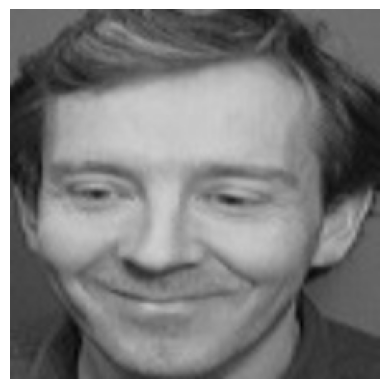

預測的類別索引為：2


In [6]:
# 獲取 test 資料夾中所有圖片的路徑
image_paths = []
for root, dirs, files in os.walk(test_folder):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
            image_paths.append(os.path.join(root, file))

# 從圖片路徑列表中隨機選擇一張圖片
random_image_path = random.choice(image_paths)

# 載入隨機選擇的圖像
image = Image.open(random_image_path)

# 顯示圖像
plt.imshow(image)
plt.axis('off')
plt.show()

# 進行圖像轉換
image = transform(image).unsqueeze(0)  # 添加批次維度

# 進行預測
with torch.no_grad():
    output = model(image)

# 解析預測結果
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class_idx = torch.argmax(probabilities).item()

# 打印預測結果
print(f"預測的類別索引為：{predicted_class_idx}")

### Indicator

In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 定義數據轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 調整圖像大小
    transforms.ToTensor(),          # 轉為 Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 標準化
])

# 加載測試數據集
test_dataset = datasets.ImageFolder(test_folder, transform=transform)

# 定義 DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 確保模型在正確的設備上

y_true = []
for _, labels in test_loader:
    y_true.extend(labels.cpu().numpy())  # 將真實標籤加入列表

y_pred = []
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)  # 確保圖像在正確的設備上
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())  # 將結果轉回 CPU 並加入列表

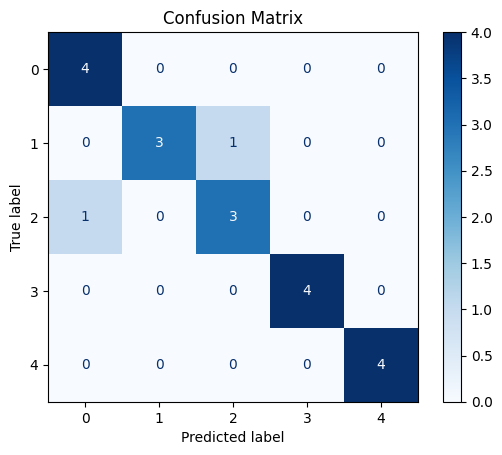

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 定義類別名稱（從 test_dataset 自動獲取）
class_names = test_dataset.classes  # 獲取測試數據的類別名稱

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)

# 顯示混淆矩陣
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

